<h1>Table of Contents<span class="tocSkip"></span></h1>


# Intoduction
<hr style = "border:2px solid black" ></hr>


**What?** Building a KMeans with PySpark MLib



# Imports
<hr style = "border:2px solid black" ></hr>

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, when
from pyspark.ml.feature import (
    VectorAssembler,
    StringIndexer,
    OneHotEncoder,
    StandardScaler,
)
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Start a spark session
<hr style = "border:2px solid black" ></hr>

In [2]:
spark = SparkSession.builder.appName('PySpark_for_DataScience').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/02 11:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read-in dataset
<hr style = "border:2px solid black" ></hr>

In [3]:
df = spark.read.csv(
    './data/spotify_weekly_chart.csv',
    sep=',',
    header=True,
)

In [4]:
df.printSchema()

root
 |-- Pos: string (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: string (nullable = true)
 |-- Pk: string (nullable = true)
 |-- (x?): string (nullable = true)
 |-- Streams: string (nullable = true)
 |-- Streams+: string (nullable = true)
 |-- Total: string (nullable = true)



- As we can observe, PySpark has loaded all of the columns as a string. 
- To perform exploratory data analysis, we need to change the Schema. 

In [5]:
data_schema = [
    StructField('Pos', IntegerType(), True),
    StructField('P+', StringType(), True),
    StructField('Artist', StringType(), True),
    StructField('Title', StringType(), True),
    StructField('Wks', IntegerType(), True),
    StructField('Pk', IntegerType(), True),
    StructField('(x?)', StringType(), True),
    StructField('Streams', IntegerType(), True),
    StructField('Streams+', DoubleType(), True),
    StructField('Total', IntegerType(), True),
]

final_struc = StructType(fields=data_schema)

In [6]:
final_struc

StructType(List(StructField(Pos,IntegerType,true),StructField(P+,StringType,true),StructField(Artist,StringType,true),StructField(Title,StringType,true),StructField(Wks,IntegerType,true),StructField(Pk,IntegerType,true),StructField((x?),StringType,true),StructField(Streams,IntegerType,true),StructField(Streams+,DoubleType,true),StructField(Total,IntegerType,true)))

- Load the CSV files again using extra argument schema.

In [7]:
df = spark.read.csv(
    './data/spotify_weekly_chart.csv',
    sep=',',
    header=True,
    schema=final_struc
)

df.printSchema()

root
 |-- Pos: integer (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: integer (nullable = true)
 |-- Pk: integer (nullable = true)
 |-- (x?): string (nullable = true)
 |-- Streams: integer (nullable = true)
 |-- Streams+: double (nullable = true)
 |-- Total: integer (nullable = true)



In [8]:
df.limit(5).toPandas()

,Pos,P+,Artist,Title,Wks,Pk,(x?),Streams,Streams+,Total
0,1,=,Miley Cyrus,Flowers,6,1,6,61763072,-9016633.0,528646130
1,2,=,SZA,Kill Bill,11,1,2,46549077,-2452314.0,510454785
2,3,+1,PinkPantheress,Boy's a liar Pt. 2,3,3,1,39172306,7520136.0,83824655
3,4,-1,Bizarrap,"Shakira: Bzrp Music Sessions, Vol. 53",7,2,3,34781301,-3881780.0,335240889
4,5,=,Harry Styles,As It Was,47,1,11,29532543,-1523395.0,1924932123


In [9]:
df.describe().show()

+-------+------------------+-------------------+-----------+------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|               Pos|                 P+|     Artist| Title|              Wks|               Pk|              (x?)|          Streams|          Streams+|              Total|
+-------+------------------+-------------------+-----------+------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               200|                200|        200|   200|              200|              200|                32|              200|               185|                192|
|   mean|             100.5|-3.3257142857142856|       null| 505.0|           44.775|            42.68|           4.40625|   1.1778173855E7|-516817.8864864865|       3.85947391E8|
| stddev|57.879184513951124| 17.479122897737746|       null|  null|62.69367479496223|42.722401829607

In [10]:
df.count()

200

# Cleaning
<hr style = "border:2px solid black" ></hr>

- You can rename your column by using withColumnRenamed function. It requires an old name and a new name as string. 

In [11]:
f = df.withColumnRenamed('Pos', 'Rank')

df.show(5)

+---+---+---------------+--------------------+---+---+----+--------+----------+----------+
|Pos| P+|         Artist|               Title|Wks| Pk|(x?)| Streams|  Streams+|     Total|
+---+---+---------------+--------------------+---+---+----+--------+----------+----------+
|  1|  =|   Miley Cyrus |             Flowers|  6|  1|   6|61763072|-9016633.0| 528646130|
|  2|  =|           SZA |           Kill Bill| 11|  1|   2|46549077|-2452314.0| 510454785|
|  3| +1|PinkPantheress |  Boy's a liar Pt. 2|  3|  3|   1|39172306| 7520136.0|  83824655|
|  4| -1|      Bizarrap |Shakira: Bzrp Mus...|  7|  2|   3|34781301|-3881780.0| 335240889|
|  5|  =|  Harry Styles |           As It Was| 47|  1|  11|29532543|-1523395.0|1924932123|
+---+---+---------------+--------------------+---+---+----+--------+----------+----------+
only showing top 5 rows



- To drop single or multiple columns, you can use drop() function.

In [12]:
df = df.drop('P+', 'Pk', '(x?)', 'Streams+')

df.show(5)

+---+---------------+--------------------+---+--------+----------+
|Pos|         Artist|               Title|Wks| Streams|     Total|
+---+---------------+--------------------+---+--------+----------+
|  1|   Miley Cyrus |             Flowers|  6|61763072| 528646130|
|  2|           SZA |           Kill Bill| 11|46549077| 510454785|
|  3|PinkPantheress |  Boy's a liar Pt. 2|  3|39172306|  83824655|
|  4|      Bizarrap |Shakira: Bzrp Mus...|  7|34781301| 335240889|
|  5|  Harry Styles |           As It Was| 47|29532543|1924932123|
+---+---------------+--------------------+---+--------+----------+
only showing top 5 rows



- You can use .na for dealing with missing valuse. In our case, we are dropping all missing values rows. 

In [13]:
df = df.na.drop()

# EDA
<hr style = "border:2px solid black" ></hr>

- For data analysis, we will be using PySpark API to translate SQL commands. In the first example, we are selecting three columns and display the top 5 rows. 

In [14]:
df.select(['Artist', 'Artist', 'Total']).show(5)

+---------------+---------------+----------+
|         Artist|         Artist|     Total|
+---------------+---------------+----------+
|   Miley Cyrus |   Miley Cyrus | 528646130|
|           SZA |           SZA | 510454785|
|PinkPantheress |PinkPantheress |  83824655|
|      Bizarrap |      Bizarrap | 335240889|
|  Harry Styles |  Harry Styles |1924932123|
+---------------+---------------+----------+
only showing top 5 rows



- Filter values where ‘Total’ is greater than or equal to 600 million to 700 million. 

In [15]:
df.filter(
    (col("Total") >= lit("600000000")) & (col("Total") <= lit("700000000"))
).show(5)

+---+-----------+-------------------+---+--------+---------+
|Pos|     Artist|              Title|Wks| Streams|    Total|
+---+-----------+-------------------+---+--------+---------+
| 12|The Weeknd |        Die For You| 58|21655432|664741027|
| 57|Steve Lacy |          Bad Habit| 33|12458884|604464538|
| 99|    Eminem |         Without Me| 87| 9450373|628174551|
|114|   KAROL G |           PROVENZA| 44| 9026567|691040730|
|135|    Eminem |The Real Slim Shady| 90| 8423035|610347150|
+---+-----------+-------------------+---+--------+---------+
only showing top 5 rows



- Write if/else statement to create a categorical column using when function.

In [16]:
df.select('Artist', 'Title',
          when(df.Wks >= 35, 1).otherwise(0)
          ).show(5)

+---------------+--------------------+---------------------------------------+
|         Artist|               Title|CASE WHEN (Wks >= 35) THEN 1 ELSE 0 END|
+---------------+--------------------+---------------------------------------+
|   Miley Cyrus |             Flowers|                                      0|
|           SZA |           Kill Bill|                                      0|
|PinkPantheress |  Boy's a liar Pt. 2|                                      0|
|      Bizarrap |Shakira: Bzrp Mus...|                                      0|
|  Harry Styles |           As It Was|                                      1|
+---------------+--------------------+---------------------------------------+
only showing top 5 rows



- You can use all of the SQL commands as Python API to run a complete query. 

In [17]:
df.select(['Artist', 'Wks', 'Total'])\
    .groupBy('Artist')\
    .mean()\
    .orderBy(['avg(Total)'], ascending=[False])\
    .show(5)

+------------------+--------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|
+------------------+--------+--------------------+
|    Billie Eilish |   253.0|       2.089105993E9|
|     James Arthur |   289.0|       1.975186494E9|
|     Harry Styles |    86.0|1.5296280663333333E9|
|The Neighbourhood |   155.0|       1.427743967E9|
|       Elton John |    80.0|       1.378850227E9|
+------------------+--------+--------------------+
only showing top 5 rows



- Let’s take above query and try to display it as a bar chart.
- We are plotting “artists v.s average song streams” and we are only displaying the top seven artists. 

In [18]:
vis_df = (
    df.select(["Artist", "Wks", "Total"])
    .groupBy("Artist")
    .mean()
    .orderBy(["avg(Total)"], ascending=[False])
    .toPandas()
)

<AxesSubplot:xlabel='Artist', ylabel='Average Average Streams'>

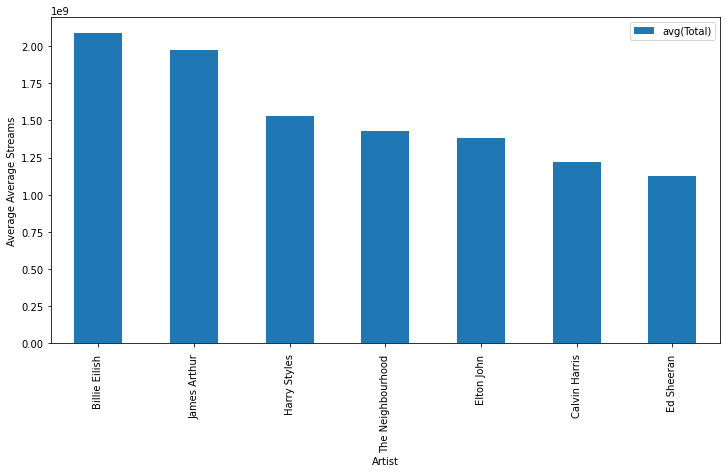

In [19]:
vis_df.iloc[0:7].plot(
    kind="bar",
    x="Artist",
    y="avg(Total)",
    figsize=(12, 6),
    ylabel="Average Average Streams",
)

# Saving locally
<hr style = "border:2px solid black" ></hr>

- You can save the results in all of the popular file types, such as CSV, JSON, and Parquet. 

In [20]:
final_data = (
    df.select(["Artist", "Wks", "Total"])
    .groupBy("Artist")
    .mean()
    .orderBy(["avg(Total)"], ascending=[False])
)

In [21]:
# CSV
final_data.write.csv("./dataset.csv")

# JSON
final_data.write.save("./dataset.json", format="json")

# Parquet
#final_data.write.save("./dataset.parquet", format="parquet")

# Pre-processing
<hr style = "border:2px solid black" ></hr>

- Categorical Encoding: converting the categorical columns into integers using StringIndexer.
- Assembling Features: assembling important features into one vector column. 
- Scaling: scaling the data using the StandardScaler scaling function.  

In [22]:
# Categorical Encoding
indexer = StringIndexer(inputCol="Artist", outputCol="Encode_Artist").fit(
    final_data
)
encoded_df = indexer.transform(final_data)

In [23]:
# Assembling Features
assemble = VectorAssembler(
    inputCols=["Encode_Artist", "avg(Wks)", "avg(Total)"],
    outputCol="features",
)
assembled_data = assemble.transform(encoded_df)

In [25]:
# Standard Scaling
scale = StandardScaler(inputCol="features", outputCol="standardized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show(5)

+------------------+--------+--------------------+-------------+--------------------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|Encode_Artist|            features|        standardized|
+------------------+--------+--------------------+-------------+--------------------+--------------------+
|    Billie Eilish |   253.0|       2.089105993E9|         10.0|[10.0,253.0,2.089...|[0.26958193300859...|
|     James Arthur |   289.0|       1.975186494E9|         43.0|[43.0,289.0,1.975...|[1.15920231193696...|
|     Harry Styles |    86.0|1.5296280663333333E9|         35.0|[35.0,86.0,1.5296...|[0.94353676553008...|
|The Neighbourhood |   155.0|       1.427743967E9|        109.0|[109.0,155.0,1.42...|[2.93844306979369...|
|       Elton John |    80.0|       1.378850227E9|         28.0|[28.0,80.0,1.3788...|[0.75482941242406...|
+------------------+--------+--------------------+-------------+--------------------+--------------------+
only showing top 5 rows



# KMeans Clustering
<hr style = "border:2px solid black" ></hr>

In [27]:
KMeans_algo = KMeans(featuresCol='standardized', k=4)
KMeans_fit = KMeans_algo.fit(data_scale_output)
preds = KMeans_fit.transform(data_scale_output)

In [28]:
preds.show(5)

+------------------+--------+--------------------+-------------+--------------------+--------------------+----------+
|            Artist|avg(Wks)|          avg(Total)|Encode_Artist|            features|        standardized|prediction|
+------------------+--------+--------------------+-------------+--------------------+--------------------+----------+
|    Billie Eilish |   253.0|       2.089105993E9|         10.0|[10.0,253.0,2.089...|[0.26958193300859...|         1|
|     James Arthur |   289.0|       1.975186494E9|         43.0|[43.0,289.0,1.975...|[1.15920231193696...|         1|
|     Harry Styles |    86.0|1.5296280663333333E9|         35.0|[35.0,86.0,1.5296...|[0.94353676553008...|         2|
|The Neighbourhood |   155.0|       1.427743967E9|        109.0|[109.0,155.0,1.42...|[2.93844306979369...|         2|
|       Elton John |    80.0|       1.378850227E9|         28.0|[28.0,80.0,1.3788...|[0.75482941242406...|         2|
+------------------+--------+--------------------+------

# Clean-up folder
<hr style = "border:2px solid black" ></hr>

In [ ]:
# remember these are directories
!rm -rf ./dataset.csv ./dataset.json

# References
<hr style = "border:2px solid black" ></hr>


- [PySpark for Data Science](https://www.kdnuggets.com/2023/02/pyspark-data-science.html)
- [Global Spotify Weekly Chart Dataset](https://www.kaggle.com/datasets/kabhishm/global-spotify-weekly-chart)
- [Pandas API on Spark](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/index.html)
    
